In [1]:
#imports del notebook anterior
import re
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
import csv
import requests

#disable warnings messages
import warnings
warnings.simplefilter("ignore")

#imports para graficar
import matplotlib.pyplot as plt
import seaborn as sns

#importando librería propia
import sys
sys.path.append('./../')

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

#Own Library modules
import src
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

from src.algorithms import eda as eda_eq

## Lectura y preparación de datos

In [2]:
# para leer el archivo como local
#agua = pd.read_csv('../data/consumo-agua.csv')

# para leer el archivo de la liga
CSV_URL = 'https://datos.cdmx.gob.mx/explore/dataset/consumo-agua/download/?format=csv&timezone=America/Mexico_City&lang=es&use_labels_for_header=true&csv_separator=%2C'
agua_liga = pd.read_csv(CSV_URL)
agua = agua_liga
agua = eda_eq.prepara_dataset(agua)

In [3]:
agua.head()

,geo_point,geo_shape,consumo_total_mixto,anio,nomgeo,consumo_prom_dom,consumo_total_dom,alcaldia,colonia,consumo_prom_mixto,consumo_total,consumo_prom,consumo_prom_no_dom,bimestre,consumo_total_no_dom,gid,indice_des,latitud,longitud
0,"19.4552601937,-99.1126617526","{""type"": ""multipolygon"", ""coordinates"": [[[[-9...",159.72,2019,gustavo a. madero,42.566364,468.23,gustavo a. madero,7 de noviembre,53.24,631.00,42.066667,3.05,3,3.05,57250,alto,19.455260,-99.112662
1,"19.4552601937,-99.1126617526","{""type"": ""multipolygon"", ""coordinates"": [[[[-9...",0.00,2019,gustavo a. madero,35.936667,107.81,gustavo a. madero,7 de noviembre,0.00,115.13,28.782500,7.32,3,7.32,57253,medio,19.455260,-99.112662
2,"19.4557195871,-99.1135822797","{""type"": ""multipolygon"", ""coordinates"": [[[[-9...",0.00,2019,gustavo a. madero,24.586000,122.93,gustavo a. madero,7 de noviembre,0.00,197.96,32.993333,75.03,3,75.03,57255,popular,19.455720,-99.113582
3,"19.4596467168,-99.1044693641","{""type"": ""multipolygon"", ""coordinates"": [[[[-9...",0.00,2019,gustavo a. madero,0.000000,0.00,gustavo a. madero,nueva tenochtitlan,0.00,253.53,84.510000,84.51,3,253.53,57267,bajo,19.459647,-99.104469
4,"19.4741606185,-99.1467497317","{""type"": ""multipolygon"", ""coordinates"": [[[[-9...",56.72,2019,azcapotzalco,67.436250,539.49,azcapotzalco,prohogar,56.72,839.35,76.304545,121.57,3,243.14,57330,bajo,19.474161,-99.146750


In [4]:
agua.dtypes

geo_point                 object
geo_shape                 object
consumo_total_mixto      float64
anio                       int64
nomgeo                  category
consumo_prom_dom         float64
consumo_total_dom        float64
alcaldia                category
colonia                 category
consumo_prom_mixto       float64
consumo_total            float64
consumo_prom             float64
consumo_prom_no_dom      float64
bimestre                category
consumo_total_no_dom     float64
gid                     category
indice_des              category
latitud                  float64
longitud                 float64
dtype: object

## Correlaciones

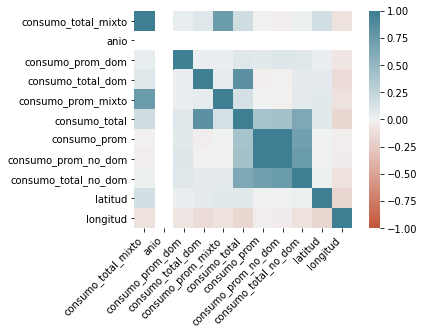

In [5]:
# analizando correlaciones
corr = agua.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Variables con correlación "alta":
* `consumo_total_mixto` vs `consumo_prom_mixto`
* `consumo_total`
* `consumo_prom`
* `consumo_prom_no_dom`
* `consumo_total_no_dom`

## Pairplot

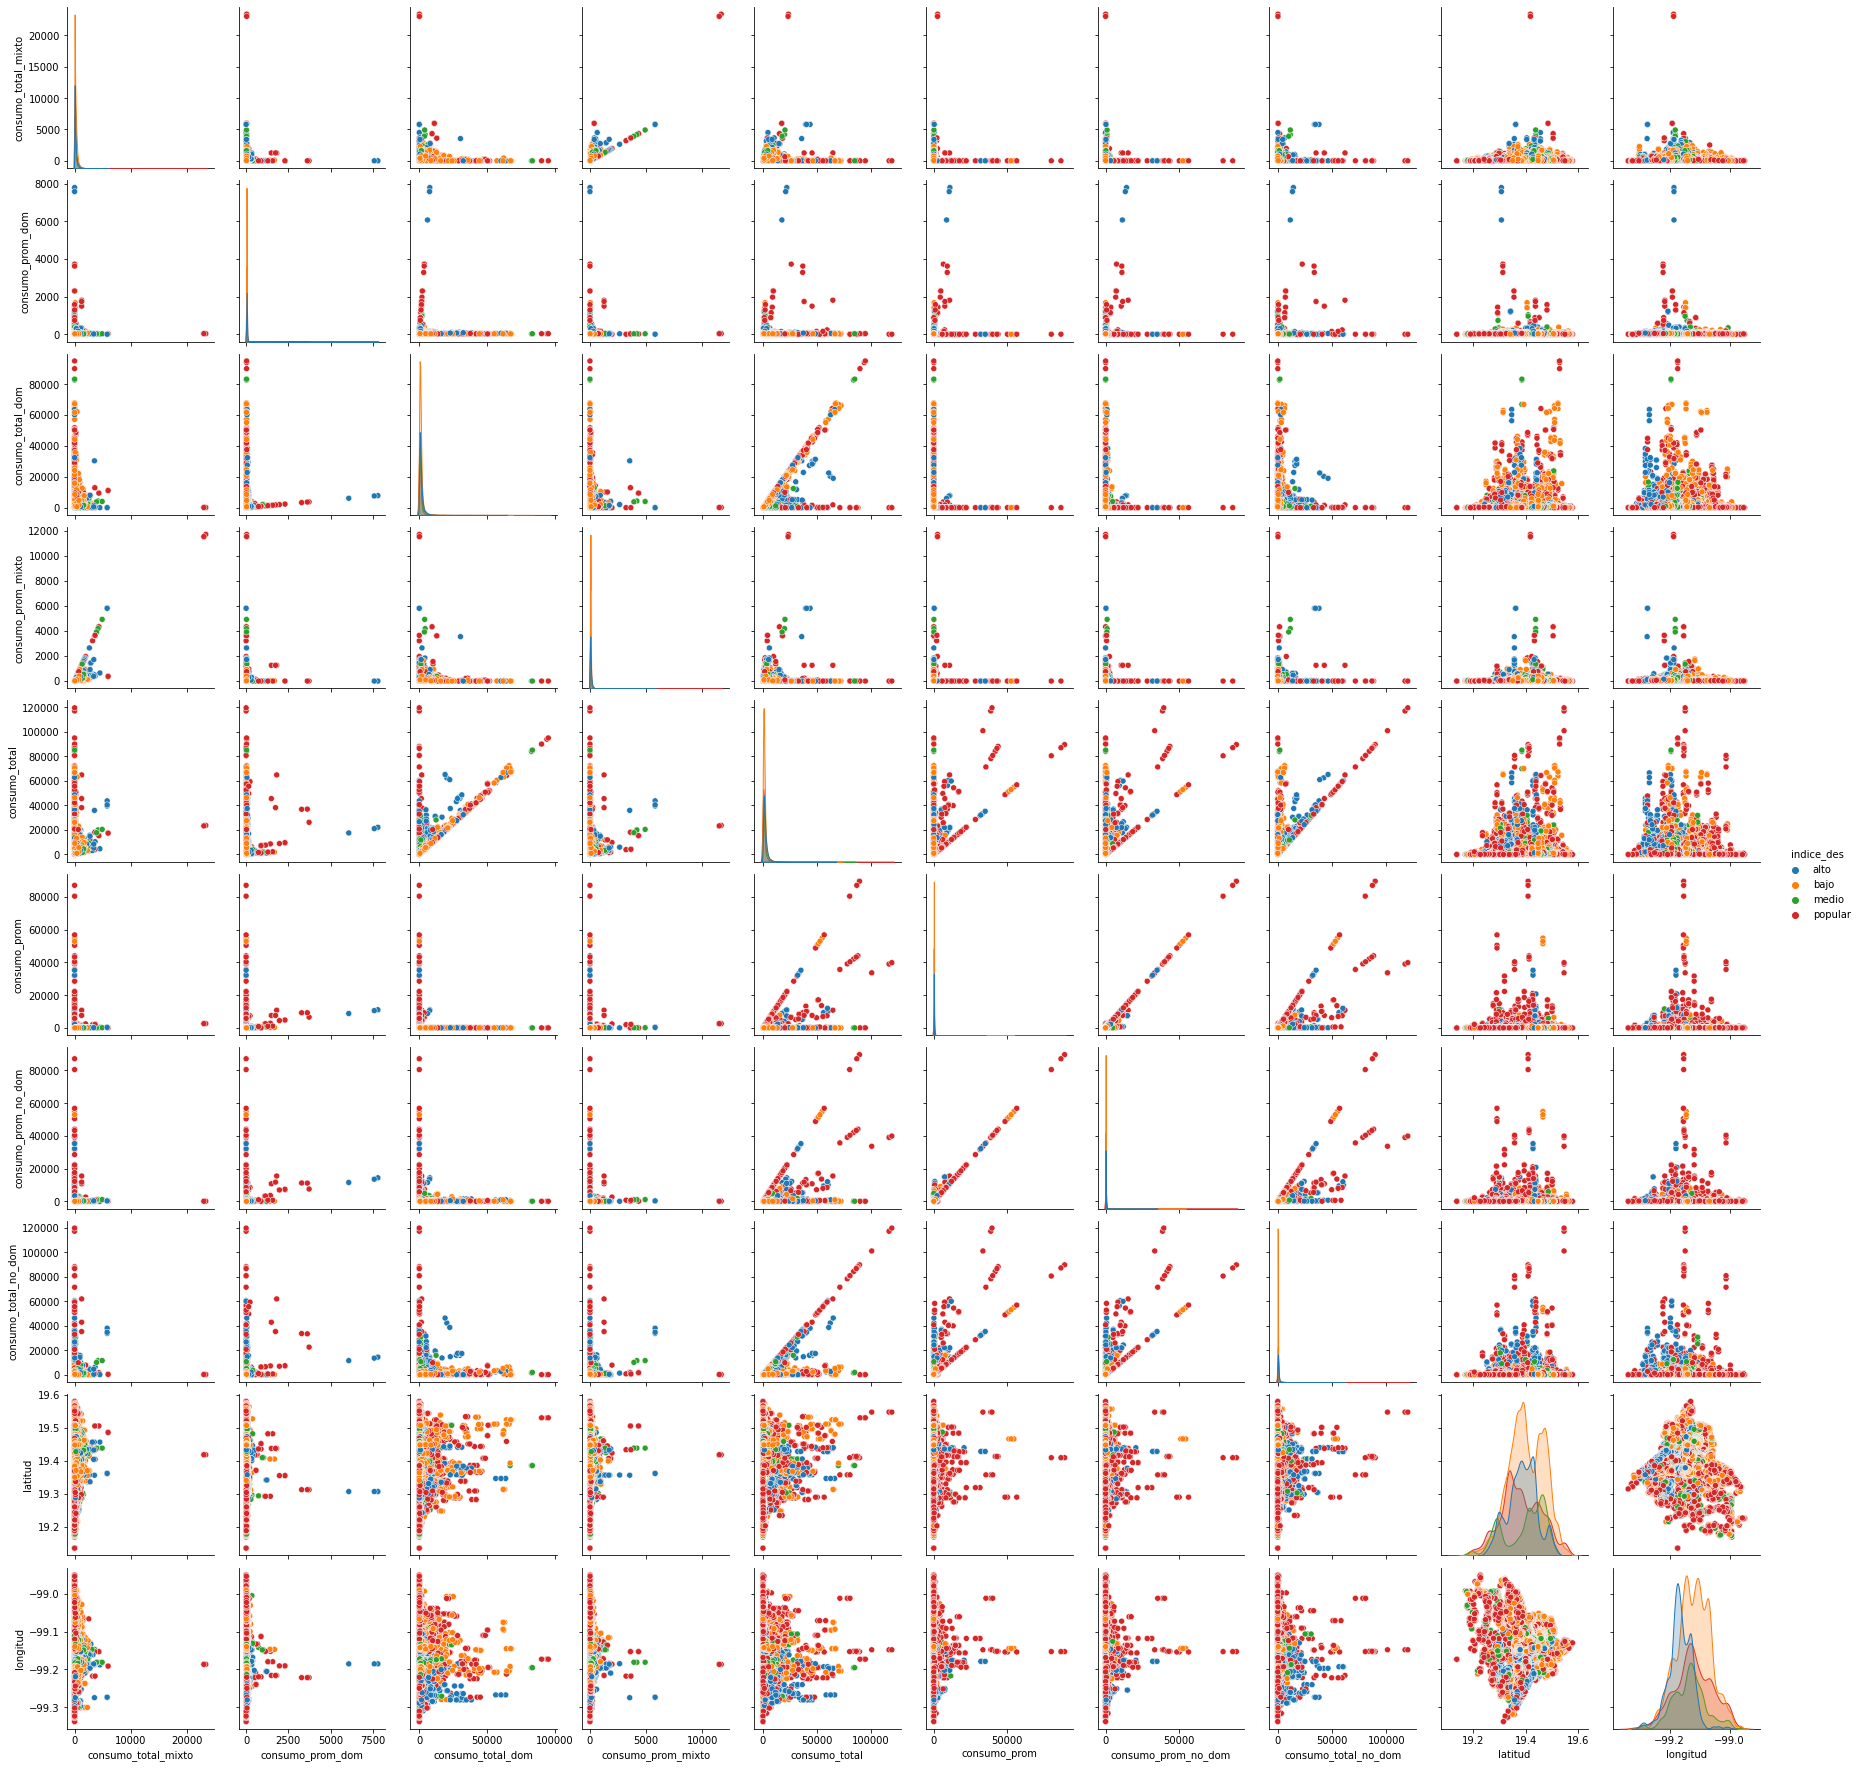

In [6]:
agua.drop(columns =["anio"], inplace = True) 
sns.pairplot(agua, hue='indice_des')

## Histogramas

In [7]:
variables_numericas = np.array(["consumo_total_mixto", "consumo_prom_dom", "consumo_total_dom", 
                                "consumo_prom_mixto", "consumo_total", "consumo_prom", "consumo_prom_no_dom",
                               "consumo_total_no_dom"])
print(variables_numericas)

['consumo_total_mixto' 'consumo_prom_dom' 'consumo_total_dom'
 'consumo_prom_mixto' 'consumo_total' 'consumo_prom' 'consumo_prom_no_dom'
 'consumo_total_no_dom']


Los siguientes histogramas muestran la **gran densidad en niveles bajos** (ceros y/o cercanos a dicho valor), además de que se logra apreciar que todas las variables poseen colas pesadas, pues hay valores muy altos para todas las variables.

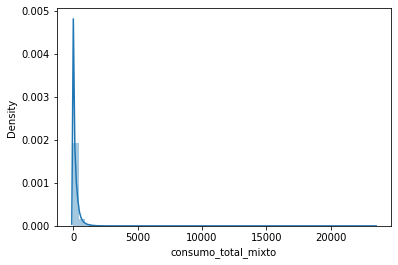

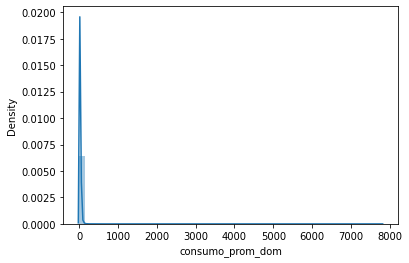

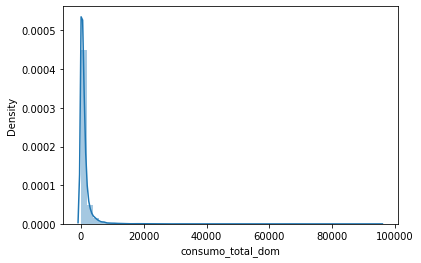

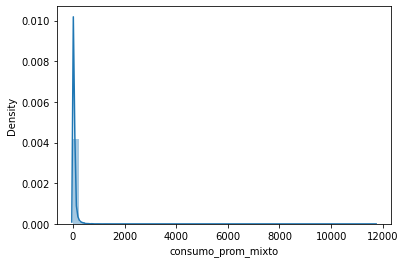

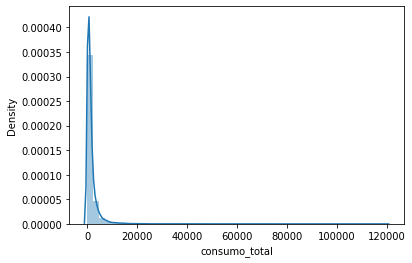

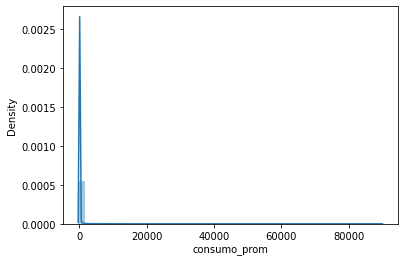

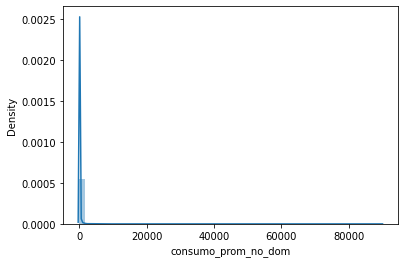

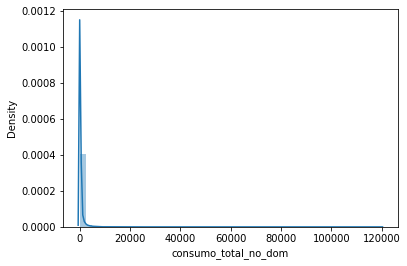

In [8]:
for column in variables_numericas:
    plt.figure()
    sns.distplot(agua[column])

In [9]:
# Filtrar por suma por renglones igual a cero
agua["suma"] = agua[variables_numericas].sum(axis=1)
agua_no_zero = agua[agua.suma == 0]
agua_no_zero = agua_no_zero[agua.columns.difference(np.append(variables_numericas, 'suma'))]

In [10]:
n_zero = agua_no_zero.shape[0]
n_agua = agua.shape[0]
print(n_zero/n_agua)

0.03447160417428483


Los valores que contienen puros ceros en las variables numéricas corresponden aproximadamente al $3.4\%$ de los datos, se preguntará a cliente porqué tenemos observaciones sin consumo de agua para dichos periodos y lugares:
* ¿Esto se debe a un error de medición o captura de los datos?
* ¿Son establecimientos que no son habitados o fueron deshabitados a lo largo del periodo en cuestión? 
* Alguna otra opción.

In [11]:
variables_categoricas = np.array(['alcaldia', 'bimestre', 'colonia', 'gid', 'indice_des', 'nomgeo'])
for column in variables_categoricas:
    aux = pd.crosstab(index = agua_no_zero[column], columns='count')
    aux = aux.sort_values('count', ascending = False)
    print(column)
    print(aux.head())

alcaldia
col_0                count
alcaldia                  
iztapalapa            1119
tlalpan                420
gustavo a. madero      159
coyoacan               136
magdalena contreras    115
bimestre
col_0     count
bimestre       
1           836
2           810
3           805
colonia
col_0                         count
colonia                            
santa maria aztahuacan           51
xalpa                            48
buenavista                       46
lomas de zaragoza                36
pueblo santa cruz meyehualco     35
gid
col_0  count
gid         
321        1
47242      1
47225      1
47226      1
47228      1
indice_des
col_0       count
indice_des       
popular      1227
bajo          952
medio         202
alto           70
nomgeo
col_0                   count
nomgeo                       
iztapalapa               1119
tlalpan                   420
gustavo a. madero         159
coyoacan                  136
la magdalena contreras    115


* La alcaldía de Iztapalapa tiene una cantidad de ceros "fuera de lo común", en el sentido de que se encuentra muy por encima d elos demás valores.
* El índice de desarrollo popular tiene una cantidad de ceros "fuera de lo común".
* Entre las demás variables, la cantidad de ceros no es fuera de lo común (los rangos de dispersión no son muy altos).

Se analizará la frecuencia de ceros por cada variable con el fin de observar la dispersión.

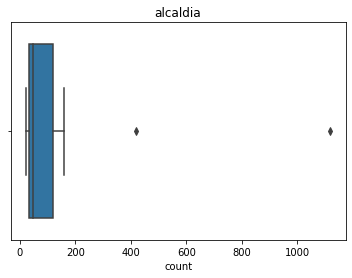

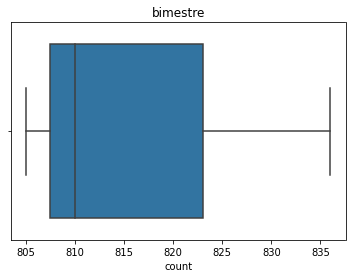

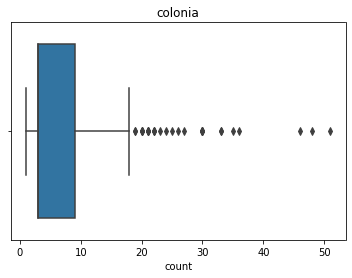

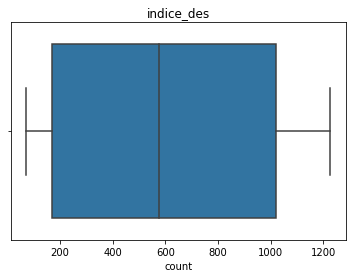

In [12]:
variables_categoricas = np.array(['alcaldia', 'bimestre', 'colonia', 'indice_des'])
for column in variables_categoricas:
    aux = pd.crosstab(index = agua_no_zero[column], columns='count')
    plt.figure(column)
    sns.boxplot(aux['count'])
    plt.title(column)

Text(0.5, 1.0, 'Distribución de ceros por alcaldías y colonias')

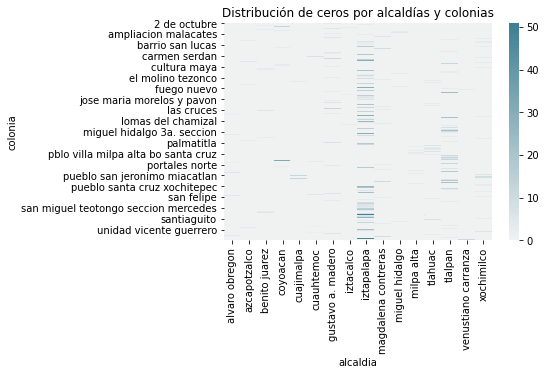

In [13]:
cross_col_alc = pd.crosstab(index = agua_no_zero['colonia'], columns =  agua_no_zero['alcaldia'])
sns.heatmap(cross_col_alc, 
            cmap = sns.diverging_palette(20, 220, n = 200), 
            center = 0).set_title('Distribución de ceros por alcaldías y colonias')

Cabe mencionar que no todas las colonias se encuentran en cada una de las alcaldías, lo cual puede confundir al lector, esta tabla muestra la cantidad de ceros que cada una de las colonias de distintas alcaldías. Nótese que las alcaldías de Iztapalapa y Tlalpan contienen una mayor cantidad de ceros, esto se debe a que son las que contienen más colonias. La siguiente tabla muestra la cantidad de colonias por alcaldía.

In [14]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'), raw=True)

n_by_alcaldia = agua_no_zero.groupby('alcaldia')['colonia'].nunique()
n_by_alcaldia = n_by_alcaldia.sort_values(ascending = False)
n_by_alcaldia = pd.DataFrame(n_by_alcaldia)

n_by_alcaldia_compl = agua.groupby('alcaldia')['colonia'].nunique()
n_by_alcaldia_compl = n_by_alcaldia_compl.sort_values(ascending = False)
n_by_alcaldia_compl = pd.DataFrame(n_by_alcaldia_compl)

display_side_by_side(n_by_alcaldia, n_by_alcaldia_compl)

,colonia
alcaldia,
iztapalapa,90
tlalpan,56
gustavo a. madero,32
xochimilco,26
tlahuac,22
magdalena contreras,20
alvaro obregon,18
coyoacan,17
milpa alta,11


En la tabla izquierada se muestra la cantidad de colonias que tiene cada alcaldía para aquellas observaciones que tienen ceros en todas las variables numéricas, mientras que en la tabla derecha se muestran los datos completos. 
Los datos no son afectados por este suceso de manera uniforme, pues se esperaría que se mantuviera el orden de las alcaldías en relación a la cantidad de colonias que poseen. Hay colonias que son más afectadas que otras, por lo que habrá que aclarar con cliente a qué se debe este fenómeno.


Text(0.5, 1.0, 'Distribución de ceros por índice de darrrollo y colonias')

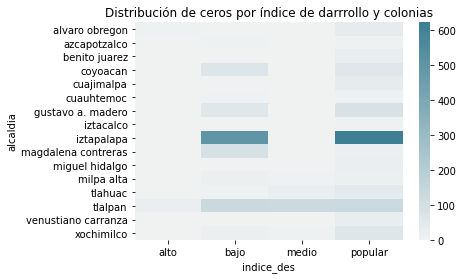

In [15]:
cross_col_alc = pd.crosstab(index = agua_no_zero['alcaldia'], columns =  agua_no_zero['indice_des'])
sns.heatmap(cross_col_alc, 
            cmap = sns.diverging_palette(20, 220, n = 200), 
            center = 0).set_title('Distribución de ceros por índice de darrrollo y colonias')

Se observa que hay un patrón: independientemente de la alcaldía, si hay ceros en el nivel popular, entonces hay ceros en el nivel bajo y viceversa, por lo que son estos $2$ ídices de desarrollo que son más afectados por la cantidad de ceros. Para el caso de Tlalpan, se incluye el índice medio.

Text(0.5, 1.0, 'Distribución de ceros por índice de darrrollo y colonias')

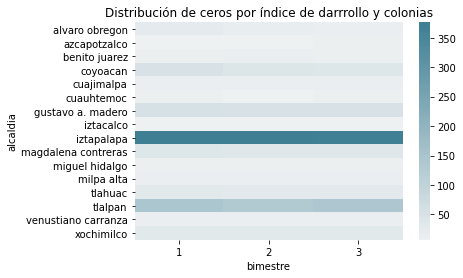

In [16]:
cross_col_alc = pd.crosstab(index = agua_no_zero['alcaldia'], columns =  agua_no_zero['bimestre'])
sns.heatmap(cross_col_alc, 
            cmap = sns.diverging_palette(20, 220, n = 200), 
            center = 0).set_title('Distribución de ceros por índice de darrrollo y colonias')

Nótese que las colonias presentan la misma cantidad de ceros a lo largo del semestre.

Text(0.5, 1.0, 'Longitud y latitud (ceros)')

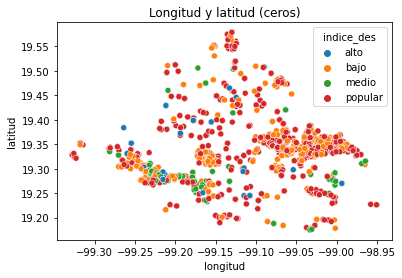

In [17]:
sns.scatterplot(x = agua_no_zero['longitud'], 
                y = agua_no_zero['latitud'], 
                hue = agua_no_zero['indice_des']).set_title('Longitud y latitud (ceros)')

Conclusión:
* Las alcaldías con mayor cantidad de ceros son Iztapalapa, seguida de Tlalpan.
* No existe una colonia o conjunto de colonias que sean afectadas por las cantidades de los ceros, lo que se puede afirmar es que todas ellas son afectadas por este "suceso" de manera uniforme, en particular las que corresponden a las alcaldías de Iztapalapa y Tlalpan.
* A lo largo del tiempo, las distintas alcaldías han tenido el mismo comportamiento.
* Los principales índices de desarrollo afectados por este "suceso" son popular, seguido del bajo.

Eliminar siguientes lineas:

[Text(0.5, 1.0, 'Índice de desarrollo - CDMX')]

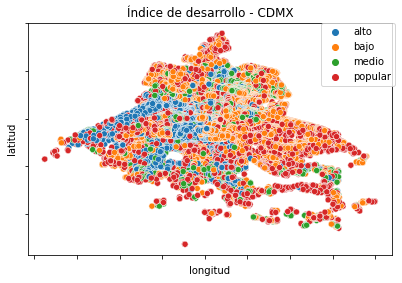

In [18]:
ax = sns.scatterplot(x = agua['longitud'], 
                y = agua['latitud'], 
                hue = agua['indice_des'])
plt.legend(bbox_to_anchor=(1.01, 1),borderaxespad=0)
plt.tight_layout()
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set(title = 'Índice de desarrollo - CDMX')

[Text(0.5, 1.0, 'Mapa representativo de CDMX por alcaldías')]

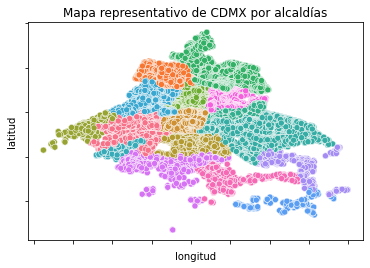

In [19]:
ax = sns.scatterplot(x = agua['longitud'], 
                         y = agua['latitud'], 
                         hue = agua['alcaldia'])
ax.legend_.remove()
ax.set(xticklabels=[])
ax.set(yticklabels=[])
ax.set(title = 'Mapa representativo de CDMX por alcaldías')